 #                                         Speech-To-Text

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imutils import paths
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\sanjeev\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Spectrogram

#### In below blog they tried with sample of wave file 
        https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/

#### Lets try with other feature like spectrogram
        Data : https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [4]:
audios_dir = r'E:\AAIC\Case Studies\Speech-To-Text\train\audio'

In [6]:
words=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

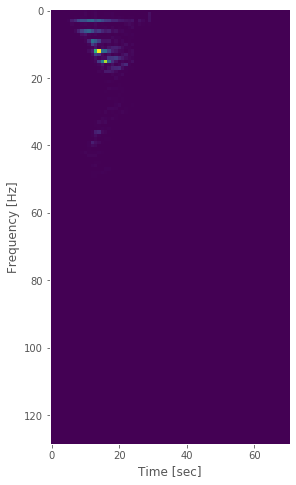

In [151]:
sample_rate, samples = wavfile.read(r'E:/AAIC/Case Studies/Speech-To-Text/train/audio/yes/00f0204f_nohash_1.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.figure(figsize=(30,8))
plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [152]:
spectrogram

array([[2.6156293e-02, 2.2892055e-01, 3.6966115e-02, ..., 1.8147479e-01,
        5.3385958e-02, 3.5170719e-02],
       [1.7347100e-01, 1.7421755e+00, 5.0767148e-01, ..., 8.8913023e-01,
        9.8591708e-02, 1.7330437e+00],
       [1.0945344e+01, 1.0747066e+01, 1.0305539e+01, ..., 6.8501520e+00,
        2.5501971e+00, 4.5086515e-01],
       ...,
       [1.5865684e-05, 3.1484353e-05, 2.7274358e-05, ..., 7.0329854e-08,
        7.8394805e-05, 3.5176196e-05],
       [5.3697636e-06, 6.5488912e-06, 6.6068346e-06, ..., 3.7657367e-06,
        2.0339318e-07, 1.5106043e-05],
       [8.8035231e-06, 8.2444130e-06, 1.4490608e-05, ..., 4.8090528e-06,
        8.5944828e-07, 2.0338655e-06]], dtype=float32)

### Load Audio Data

In [77]:
data = []
labels = []
dirs = os.listdir(audios_dir)
for d in dirs:
    if d in words:
        print(d)
        files = os.listdir(os.path.join(audios_dir,d))
        audios = [f for f in files if f.endswith('.wav')]
        for file in audios:
            # load the image, swap color channels, and resize it to be a fixed
            # 224x224 pixels while ignoring aspect ratio
            #file = audios[i]
            sample_rate, samples = wavfile.read(os.path.join(audios_dir,d,file))
            frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

            # convert the image data to NumPy arrays while scaling the pixel
            # intensities to the range [0, 255]
            #image = np.array(image)/255.0
            
            # update the data and labels lists, respectively
            if spectrogram.shape[0] >= 128 and spectrogram.shape[1] >=48:
                data.append(spectrogram[:128,:48])
                labels.append(d)
            #else:
             #   print(spectrogram.shape)


down
go
left
no
off
on
right
stop
up
yes


In [81]:
data = np.array(data)

In [82]:
data.shape

(23455, 128, 48)

### Class distribution

In [135]:
values,count = np.unique(labels,return_counts=True)

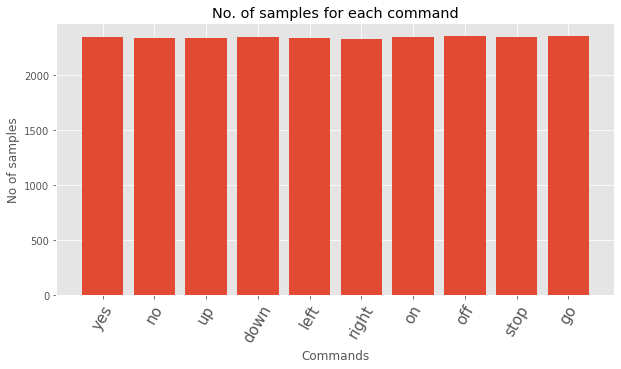

In [142]:
import matplotlib.pyplot as plt
#plot
plt.figure(figsize=(10,5))
index = np.arange(len(words))
plt.bar(index, count)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of samples', fontsize=12)
plt.xticks(index, words, fontsize=15, rotation=60)
plt.title('No. of samples for each command')
plt.show()

In [83]:
len(labels)

23455

In [84]:
labels_backup = labels

In [85]:
# convert the labels to NumPy arrays while scaling the pixel
labels = np.array(labels)

In [86]:
# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ls = le.fit_transform(labels)

In [87]:
labels_categoricals = to_categorical(ls)

In [88]:
labels_categoricals

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [89]:
labels_categoricals.shape

(23455, 10)

### Data splitting - Train,CV and Test 

In [90]:
# partition the data into training,cross-validation and testing splits using 60%,20% and 20% of data
(trainX, testX, trainY, testY) = train_test_split(data, labels_categoricals,test_size=0.20, stratify=labels_categoricals, random_state=42)
(trainX, cvX, trainY, cvY) = train_test_split(trainX, trainY,test_size=0.25, stratify=trainY, random_state=42)

In [91]:
print("Train data size : ",trainX.shape)
print("Cross-Validation data size : ",cvX.shape)
print("Test data size : ",testX.shape)

Train data size :  (14073, 128, 48)
Cross-Validation data size :  (4691, 128, 48)
Test data size :  (4691, 128, 48)


In [92]:
del data
del labels_categoricals

In [93]:
from keras import backend as K

# input image dimensions
img_rows, img_cols = 128, 48

if K.image_data_format() == 'channels_first':
    trainX = trainX.reshape(trainX.shape[0], 1, img_rows, img_cols)
    testX = testX.reshape(testX.shape[0], 1, img_rows, img_cols)
    cvX = cvX.reshape(cvX.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    trainX = trainX.reshape(trainX.shape[0],img_rows, img_cols,1)
    testX = testX.reshape(testX.shape[0],img_rows, img_cols,1)
    cvX = cvX.reshape(cvX.shape[0],img_rows, img_cols,1)
    input_shape = (img_rows, img_cols,1)

In [94]:
print("Number of training examples :", trainX.shape[0], "and each image is of shape :",trainX.shape)
print("Number of cross validation examples :", cvX.shape[0], "and each image is of shape :",cvX.shape)
print("Number of testing examples :", testX.shape[0], "and each image is of shape :",testX.shape)

Number of training examples : 14073 and each image is of shape : (14073, 128, 48, 1)
Number of cross validation examples : 4691 and each image is of shape : (4691, 128, 48, 1)
Number of testing examples : 4691 and each image is of shape : (4691, 128, 48, 1)


### VGG16 Model

In [95]:
#initialize the initial learning rate, number of epochs to train for and batch size
INIT_LR = 1e-3
EPOCHS = 150
batch_size = 32
num_class = 10
#input_shape = (224,224,3) #(513, 800, 3)

In [96]:
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.layers import Dropout,Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [97]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(2, 2),padding='same',activation='relu',input_shape=input_shape))
model.add(Conv2D(16, kernel_size=(2, 2),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(32, kernel_size=(2, 2),padding='same',activation='relu'))
model.add(Conv2D(64, kernel_size=(2, 2),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(128, kernel_size=(2, 2),padding='same',activation='relu'))
model.add(Conv2D(256, kernel_size=(2, 2),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 48, 8)        40        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 48, 16)       528       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 24, 16)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 24, 16)        64        
_________________________________________________________________
dropout_9 (Dropout)          (None, 64, 24, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 24, 32)        2080      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 24, 64)       

In [98]:
#from tensorflow.keras.optimizers import Adam
#opt = Adam(lr=INIT_LR)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [101]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [102]:
history = model.fit(trainX, trainY, batch_size=batch_size, epochs=EPOCHS, verbose=1, callbacks=[es,mc],validation_data=(cvX, cvY))

Train on 14073 samples, validate on 4691 samples
Epoch 1/150
 5888/14073 [===========>..................] - ETA: 4:50 - loss: 3.6077 - accuracy: 0.03 - ETA: 4:37 - loss: 2.8890 - accuracy: 0.07 - ETA: 4:33 - loss: 2.6552 - accuracy: 0.08 - ETA: 4:30 - loss: 2.6529 - accuracy: 0.09 - ETA: 4:28 - loss: 2.6256 - accuracy: 0.08 - ETA: 4:27 - loss: 2.5708 - accuracy: 0.09 - ETA: 4:25 - loss: 2.5404 - accuracy: 0.10 - ETA: 4:23 - loss: 2.5466 - accuracy: 0.11 - ETA: 4:21 - loss: 2.5259 - accuracy: 0.11 - ETA: 4:20 - loss: 2.4974 - accuracy: 0.11 - ETA: 4:18 - loss: 2.5311 - accuracy: 0.10 - ETA: 4:18 - loss: 2.5388 - accuracy: 0.10 - ETA: 4:18 - loss: 2.5424 - accuracy: 0.11 - ETA: 4:17 - loss: 2.5250 - accuracy: 0.10 - ETA: 4:16 - loss: 2.5088 - accuracy: 0.10 - ETA: 4:15 - loss: 2.4969 - accuracy: 0.10 - ETA: 4:13 - loss: 2.4849 - accuracy: 0.10 - ETA: 4:12 - loss: 2.4780 - accuracy: 0.10 - ETA: 4:11 - loss: 2.4665 - accuracy: 0.11 - ETA: 4:09 - loss: 2.4769 - accuracy: 0.10 - ETA: 4:08 - 

C:\Users\sanjeev\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/150
 5920/14073 [===========>..................] - ETA: 5:08 - loss: 2.3036 - accuracy: 0.0000e+ - ETA: 5:16 - loss: 2.3030 - accuracy: 0.0156   - ETA: 5:13 - loss: 2.3030 - accuracy: 0.03 - ETA: 5:00 - loss: 2.3027 - accuracy: 0.05 - ETA: 4:53 - loss: 2.3027 - accuracy: 0.06 - ETA: 4:50 - loss: 2.3027 - accuracy: 0.05 - ETA: 4:48 - loss: 2.3027 - accuracy: 0.06 - ETA: 4:48 - loss: 2.3028 - accuracy: 0.06 - ETA: 4:47 - loss: 2.3031 - accuracy: 0.07 - ETA: 4:46 - loss: 2.3032 - accuracy: 0.07 - ETA: 4:49 - loss: 2.3034 - accuracy: 0.08 - ETA: 4:49 - loss: 2.3032 - accuracy: 0.07 - ETA: 4:48 - loss: 2.3032 - accuracy: 0.07 - ETA: 4:45 - loss: 2.3031 - accuracy: 0.08 - ETA: 4:45 - loss: 2.3031 - accuracy: 0.08 - ETA: 4:44 - loss: 2.3030 - accuracy: 0.08 - ETA: 4:43 - loss: 2.3030 - accuracy: 0.09 - ETA: 4:43 - loss: 2.3030 - accuracy: 0.09 - ETA: 4:41 - loss: 2.3020 - accuracy: 0.09 - ETA: 4:39 - loss: 2.3021 - accuracy: 0.09 - ETA: 4:37 - loss: 2.3021 - accuracy: 0.09 - ETA: 4:35

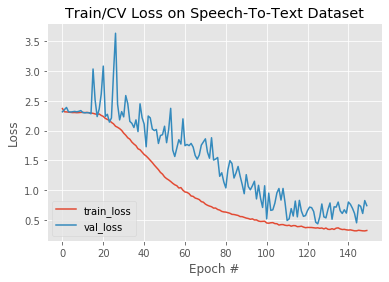

In [108]:
# plot the training loss
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Train/CV Loss on Speech-To-Text Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

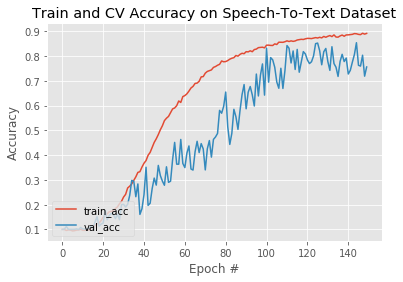

In [109]:
# plot the training accuracy
N = EPOCHS
#plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Train and CV Accuracy on Speech-To-Text Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [111]:
best_acc = max(history.history["val_accuracy"])

In [113]:
best_acc*100

85.4188859462738

In [114]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=batch_size)

In [115]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [133]:
def plot_Confusion_Matrix(actual_labels,predict_labels,title):
    """This function plot the confusion matrix"""
    # Reference : https://seaborn.pydata.org/generated/seaborn.heatmap.html
    cm = confusion_matrix(actual_labels, predict_labels)
    classNames = words
    cm_data = pd.DataFrame(cm,index = classNames,
                  columns = classNames)
    plt.figure(figsize = (8,8))
    sns.heatmap(cm_data, annot=True,fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


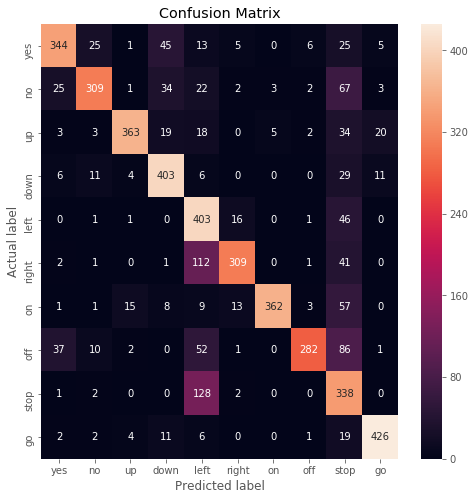

In [134]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

plot_Confusion_Matrix(testY.argmax(axis=1), predIdxs,"Confusion Matrix")

## Results

In [156]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Results "
ptable.field_names = ["Mode",'Sample size','Accuracy']
ptable.add_row(["Train","14073","89.03"])
ptable.add_row(["Cross-Validation","4691","85.41"])
ptable.add_row(["Test","4691","85.44"])
print(ptable)

+-------------------------------------------+
|               Model Results               |
+------------------+-------------+----------+
|       Mode       | Sample size | Accuracy |
+------------------+-------------+----------+
|      Train       |    14073    |  89.03   |
| Cross-Validation |     4691    |  85.41   |
|       Test       |     4691    |  85.44   |
+------------------+-------------+----------+
